# Data Science Challenge
#### Hitanshu Pande  |  513-580-6169 |  hitanshu.pande@gmail.com
#### 727 MLK Dr W, Apt 903W, Cincinnati-45220 
----------------------------------------------------------

<b>Challenge</b>:
Build a predictive model that can identify a shopper’s likelihood to return to the store next week (Sun – Sat) AND purchase less than 3 units based on their past shopping behavior. 


<b>Deliverables</b>:
Recommend a model that best solves the problem, expected model performance  and any other findings
What additional data that might improve your model performance
“Show your work” - any background on how you got your recommended model.


<b>Data</b>:
Each observation is trip to the retail store. 
The data contains all trips for a sample of shoppers from 3/20/2015 – 3/26/2016

## Solution
-----------------------------------------------------------
Let's take a look at the raw data and perform some initial exploratory analysis

In [22]:
import pandas as pd
import numpy as np
import pylab as plt
import os
import datetime
%matplotlib inline  
os.chdir('D:\Python\Catalina Challenge')
df = pd.read_csv("data_science_challenge_samp_18.csv")
df.dtypes

cust_id              int64
order_date          object
lane_number          int64
total_spend        float64
units_purchased      int64
dtype: object

In [9]:
df.head()

,cust_id,order_date,lane_number,total_spend,units_purchased
0,4239597436,3/20/2015,3,19.84,5
1,4913827536,3/20/2015,3,11.1,5
2,4913827536,3/20/2015,1,10,1
3,4271866537,3/20/2015,5,13.68,2
4,5316845735,3/20/2015,4,5.29,1


From the given data, here is what we can say about the following variables:


| Column        | Details           | 
| ------------- |-------------| 
| cust_id     | This is the unique identifier for each customer. Same customer id appears multiple times which indicates that the same customer has made multiple purchases. Sometimes on the same day | 
| order_date      | This is the date the transaction took place.      |
| lane_number | This is the lane number where the transaction was registered. For the purpose of this challenge, we will not use this feature      |
| total_spend | Total amount that was spent in that given transaction  |
| units_purchased | Total units that were purchased in that given transaction  |

As seen above, since the data type of "order_date" is object, we want to change it to Date/Time

In [14]:
df['order_date'] = pd.to_datetime(df['order_date'])
df.dtypes

cust_id                     int64
order_date         datetime64[ns]
lane_number                 int64
total_spend               float64
units_purchased             int64
dtype: object

### Check for missing data

In [20]:
#Applying per column:
def num_missing(x):
  return sum(x.isnull())
print("Missing values per column:")
print(df.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

Missing values per column:
cust_id            0
order_date         0
lane_number        0
total_spend        0
units_purchased    0
dtype: int64


As we see above, there are no missing values in our dataset

### How many unique customers are there?

In [18]:
df['cust_id'].unique().size

12489

### Distribution of total spend and units purchased by each customer

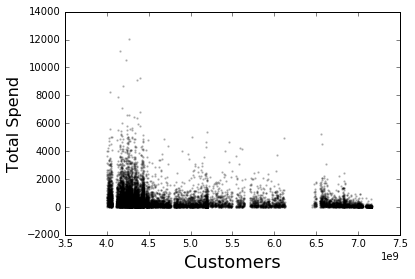

In [26]:
# Group data by Customer ID
a = df.groupby(['cust_id']).sum()
a = a.reset_index()
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Total Spend', fontsize=16)
plt.scatter(a['cust_id'],a['total_spend'],color='k',alpha=.2,s=2)


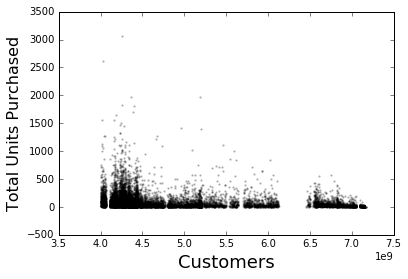

In [27]:
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Total Units Purchased', fontsize=16)
plt.scatter(a['cust_id'],a['units_purchased'],color='k',alpha=.2,s=2)

As we see in the two graphs above, the median total spend for each customer seems to lie somewhere between 0 and 2000. Similarly, the median total units purchased for each customer seems to lie between 0 and 500. There are outliers where the total spend and total units bought see much higher values.

We can also observe that there is a high corelation between total spend and total units purchased by each customer as the 2 graphs have near identical distributions.

The gap in the x-axis for Customers signifies a lack to assigned Customer IDs between 6000000000 and 640000000.


### Distribution of total sales by day

In [31]:
df['order_date'] = pd.to_datetime(df['order_date'])


cust_id                     int64
order_date         datetime64[ns]
lane_number                 int64
total_spend               float64
units_purchased             int64
dtype: object

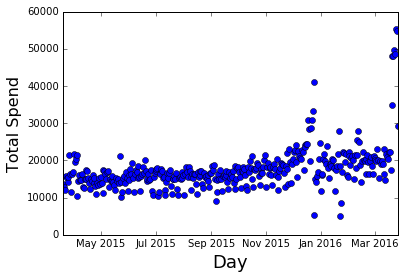

In [33]:
sales_by_day = df.groupby(['order_date']).sum()
sales_by_day = sales_by_day.reset_index()
sales_by_day.dtypes

x = sales_by_day['order_date']
y = sales_by_day['total_spend']
plt.plot_date(x, y, xdate='True')
plt.xlabel('Day', fontsize=18)
plt.ylabel('Total Spend', fontsize=16)
#plt.plot_date(x, y, xdate='True')

There are 2 visible spikes in sales during the year. One is in December, during Christmas. There is also a steep fall in sales immediately after Christmas. There is another spike in sale during March.

### Distribution of total units sold by week and day 

Let's look at how sale of units is distributed across weeks in a year and the day of the week

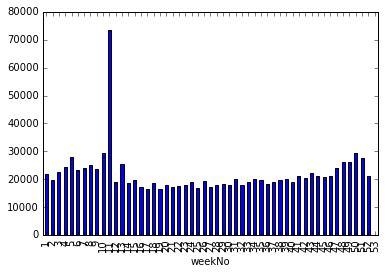

In [46]:
df2 = df
# Assign a week number to each date
df2['weekNo'] = df2['order_date'].dt.week
df2['dayOfWeek'] = df2['order_date'].dt.weekday_name
#Check sales by week
weekly_sales = df2.groupby('weekNo').sum()
weekly_sales = weekly_sales.reset_index()
weekly_units = pd.Series(weekly_sales['units_purchased'], index=weekly_sales['weekNo'])
weekly_units.plot.bar()


For the most part, total units sold do not show a lot of deviation from mean. However, week#11 shows a massive spike in units sold. It is unclear from the given data what the cause of that might be.

### Distribution of units sold by day of week

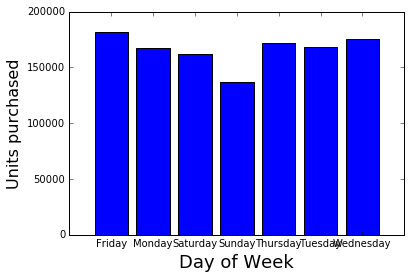

In [60]:
#Check sales by day of week
sale_by_day = df2.groupby('dayOfWeek').sum()
sale_by_day = sale_by_day.reset_index() 

sale_by_day
DayOfWeekOfCall = [0,1,2,3,4,5,6]
LABELS = ["Friday", "Monday", "Saturday", "Sunday", "Thursday", "Tuesday", "Wednesday"]
plt.bar(DayOfWeekOfCall, sale_by_day['units_purchased'], align='center')
plt.xticks(DayOfWeekOfCall, LABELS)
plt.xlabel('Day of Week', fontsize=18)
plt.ylabel('Units purchased', fontsize=16)
plt.show()
#x = sale_by_day['dayOfWeek']
#y = sale_by_day['units_purchased']
#plt.plot_date(x, y, xdate='True')


Total units purchased vary quite a bit based on the day of the week. Friday had the maximum sales, whereas Sunday recorded lowest sale over the period of a year.

## Build a predictive model that can identify a shopper’s likelihood to return using Customer Lifetime Value (CLV)

Faced with a dataset containing information on the frequency and timing of transactions for a list of past customers, it is natural to try to make forecasts about future purchasing patterns. These projections often range from aggregate sales trajectories (e.g., for the next 52 weeks), to individual-level conditional expectations (i.e., the best guess about a particular customer’s future purchasing, given information about his past behavior).

For me, this problem falls under the broader umbrella of the Customer Lifetime Value calculation. CLV research aims to model the net revenue that can be extracted from a customer. Getting a successful model to calculate CLV allows firms to adjust their marketing strategies, pricing and handling churn. 

There are two broad distinctions in which the CLV model falls under. 

### 1. Contractual  2. Non-Contractual

Contractual models are for purchases that  generally fall under a contract, eg: Monthly subscriptions, Credit Card Payments, etc. The data set given to us is a Non-Contractual one, as the customer is under no contract or obligation to make a purchase.

One of the first models to explicitly address the Non-Contractual model is the Pareto/NBD “Counting Your Customers” framework originally proposed by Schmittlein, Morrison, and Colombo (1987) which uses the RFM technique.

RFM refers to a modelling technique that utilises Recency Frequency and Monetary (RFM) data from client records 

In order to calculate the probability of purchase, the most common models used are the <b>Pareto/NBD Model</b> or it's variation <b>BG/NBD</b> model.

From our dataset, we know how many transaction occurreds in each of a series of discrete time-intervals. For example, the following transaction history:

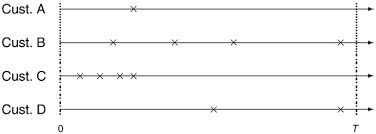

In [66]:
from IPython.core.display import Image
Image(filename=('C:/Users/Hitanshu/Pictures/RFM.jpg'))

The image(reference only) above shows the number of transactions carried out by each customer in a given Time period T. Given our problem statement, we want to estimate if a given customer will make a transaction the next week. 

The first step to customer analysis is to find a good mathematical model to describe customer repeat purchases.  This doesn't have to get complicated, Fader and Hardie only consider timing as a primary factor.  There have been quite a few canonical models proposed, first is called the Pareto/NBD Model by Schmittlein et al. in 1984.  An alternate and easier to implement model called the BG/NBD model was later proposed by Fader and Hardie

Heres a run down of the BG/NBD model (surprisingly simple actually):  Customers will come and buy at an interval that's randomly distributed within a reasonable time range.  After each purchase they have a certain probability of dying or becoming inactive (never returning to buy again).  Each customer is different and have varying purchase intervals and probability of going inactive.

<b>The BG/NBD model only requires three primary components for each unique customer:</b>

Frequency: The number of repeat purchases that they have made.


Recency: When was the last time that they have made a purchase since their first purchase.


Customer Age: The end of our observation period minus out the period that they made their first purchase.

In [67]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(df, 'cust_id', 'order_date','units_purchased', observation_period_end='2016-03-27')
summary.head()

,frequency,recency,T,monetary_value
cust_id,,,,
4239597436,69.0,372.0,373.0,4.406780
4913827536,13.0,372.0,373.0,3.181818
4271866537,103.0,369.0,373.0,2.654321
5316845735,89.0,372.0,373.0,1.647059
4396245635,93.0,370.0,373.0,4.164384


In [68]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])


D:\Anaconda3\lib\site-packages\lifetimes\estimation.py:578: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


<lifetimes.BetaGeoFitter: fitted with 12489 subjects, a: 0.00, alpha: 15.18, b: 1.53, r: 1.25>

D:\Anaconda3\lib\site-packages\lifetimes\estimation.py:618: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


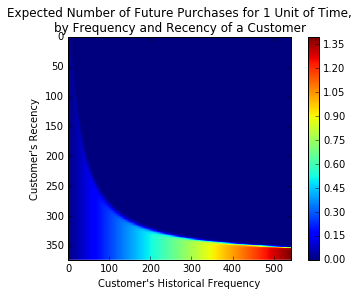

In [69]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 500 times, and their lastest purchase was when they were 350 days old (given the individual is 350 days old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven't seen them in days.

D:\Anaconda3\lib\site-packages\lifetimes\estimation.py:636: RuntimeWarning: overflow encountered in power
  return 1. / (1 + (frequency > 0) * (a / (b + frequency - 1)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))


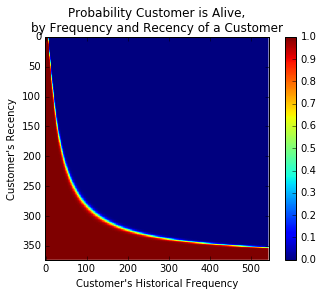

In [70]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [71]:
#Ranking customers from best to worst
#Let's return to our customers and rank them from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,monetary_value,predicted_purchases
cust_id,,,,,
7048138234,60.0,33.0,35.0,7.346154,1.220693
4232061834,511.0,371.0,373.0,5.346774,1.319631
4302370736,539.0,373.0,373.0,3.909396,1.391763
4257909036,532.0,340.0,340.0,9.960784,1.501364
5183161534,542.0,340.0,342.0,8.471861,1.520955


<b>Assuming time period as 1 day, we can see that Customer ID 5183161534 who has made a purchase of 542 times, and has made a purchase most recently, is most likely to purchase again.</b>

### Assessing model fit

Ok, we can predict and we can visualize our customers' behaviour, but is our model correct? There are a few ways to assess the model's correctness. The first is to compare our data versus artifical data simulated with our fitted model's parameters.

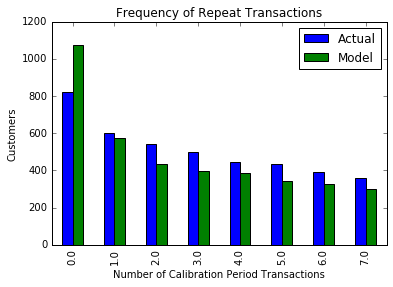

In [72]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

We can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (cross-validation in standard machine learning literature). 

In [73]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'cust_id', 'order_date',
                                        calibration_period_end='2015-12-31',
                                        observation_period_end='2016-03-27' )   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
cust_id,,,,,
4239597436,60.0,281.0,286.0,7,87
4913827536,10.0,276.0,286.0,3,87
4271866537,90.0,285.0,286.0,13,87
5316845735,71.0,285.0,286.0,17,87
4396245635,75.0,267.0,286.0,15,87


With this dataset, we can perform fitting on the _cal columns, and test on the _holdout columns:

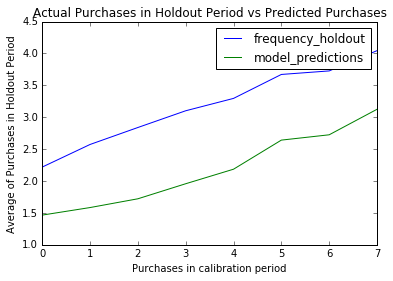

In [75]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

So we can see that our model gives a conservative estimate of purchases made, which is a decent model to predict any purchases made in the future.

### Customer Predictions

Based on customer history, we can predict what an individuals future purchases might look like:

In [76]:
t = 7 #predict purchases in 7 periods (in this case days)
individual = summary.iloc[10000]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.30963553485765066

<b>Here, we can see that our model has given a 30.9% probability that the customer id at location 10000 will make a purchase in the next 7 days.</b>

### Estimating Customers' Purchased Units

For this whole time we didn't take into account the number of units for each transaction and we focused mainly on transactions' occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. units purchased).

In [83]:
summary_with_units_value = summary_data_from_transaction_data(df, 'cust_id', 'order_date','units_purchased', observation_period_end='2016-03-27')
summary_with_units_value.head()


,frequency,recency,T,monetary_value
cust_id,,,,
4239597436,69.0,372.0,373.0,4.406780
4913827536,13.0,372.0,373.0,3.181818
4271866537,103.0,369.0,373.0,2.654321
5316845735,89.0,372.0,373.0,1.647059
4396245635,93.0,370.0,373.0,4.164384


In [84]:
#Filter by Purchase frequency > 0
returning_customers_summary = summary_with_units_value[summary_with_units_value['frequency']>0]

#Filter by Units Purchased < 3
returning_customers_summary2 = returning_customers_summary[returning_customers_summary['monetary_value']<3]
returning_customers_summary2.head()

,frequency,recency,T,monetary_value
cust_id,,,,
4271866537,103.0,369.0,373.0,2.654321
5316845735,89.0,372.0,373.0,1.647059
4046493433,87.0,372.0,373.0,2.795181
4186945433,227.0,371.0,373.0,1.591623
4223423334,24.0,365.0,372.0,2.380952


#### This is the shortlist customers who will have a purchase frequency > 0 and number of units purchased < 3. Next we will predict  the number of purchases that will be made by these customers in the coming 7 days.

In [82]:
bgf.predict(t, returning_customers_summary2['frequency'], returning_customers_summary2['recency'], returning_customers_summary2['T'])
# t = 7 days

cust_id
4271866537    1.887516
5316845735    1.633672
4046493433    1.597376
4186945433    4.137871
4223423334    0.455162
4437644235    0.091560
4303877234    0.146678
4435875536    1.042845
4128233833    0.809338
4277121833    0.570258
4473439534    0.332153
5038473134    0.627127
4347922434    0.903554
4019821234    0.906027
4186974137    0.713908
4163347937    0.791167
4328344535    0.510152
4204217936    0.340256
5732619536    0.493962
4352278836    0.399040
5600340733    0.892605
4989149437    0.215017
4016008136    0.316113
5002759037    0.357576
4303863233    0.315984
6584461737    0.237522
6500304437    0.409932
5170443836    0.371638
6652100034    0.396570
6653819036    0.174407
                ...   
4481288437    0.236891
4277113736    0.509737
4259474235    0.091560
4328316934    0.515187
4181004733    0.499377
4878834537    0.260509
4128225736    0.373942
4328344534    0.169377
4227770535    0.263299
4245350035    0.357170
5801503835    0.132184
4618399234    0.565313
490

### So we can see that Customer Id 4271866537 is expected to make 1.88 purchases in the next 7 days! There are 4275 customers in this list.

## Next Steps

### Additional Data that might help

In this dataset, we only had information of transaction date, amount and number of units for a given customer id. If the end objective is to create user segments that will be used for marketing campaigns, we can do a lot with more data points.

1. Gender
2. Age
1. Medium of Purchase
1. Reviews
4. Click stream data
5. Discounts availed
6. Income of customer

These are a few data points that could help with better segmentation of users. 